#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
from fastmri import evaluate
import torch

/home/lrobaina/school/IMPACT-MRI/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

# Masked Testing Data

In [2]:
example_data = '../data/example_data/example_data1.h5'
hf = h5py.File(example_data)

In [3]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'acquisition': 'CORPD_FBK', 'num_low_frequency': 15, 'patient_id': '7caa58f35a3bfa03f97b56c66427b60e16f011fdec9af4e9985dc5a2befededd'}


For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [4]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(35, 640, 372)


In [5]:
slice_kspace = volume_kspace

Let's see what the absolute value of k-space looks like:

In [6]:
def show_multiple_slices(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [7]:
def show_slice(data, cmap=None):
    fig = plt.figure()
    plt.imshow(data, cmap=cmap)

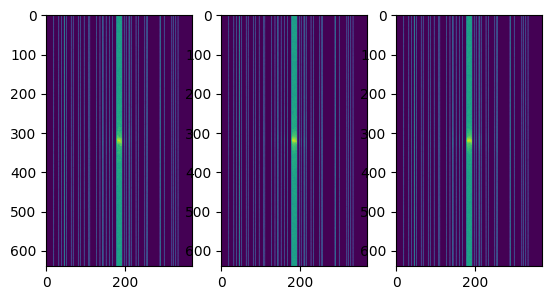

In [8]:
show_multiple_slices(np.log(np.abs(slice_kspace) + 1e-9), [10,20,30]) #show the 10th, 20th, and 30th slices

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [9]:
import fastmri
from fastmri.data import transforms as T

In [10]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

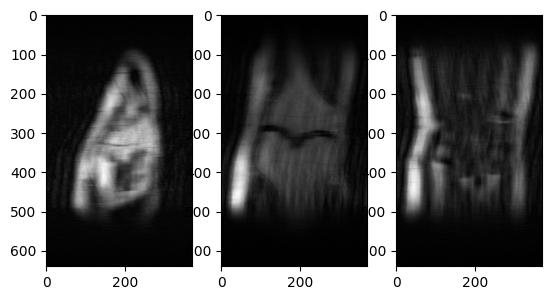

In [11]:
show_multiple_slices(slice_image_abs, [10,20,30], cmap='gray')

MR imaging is an indirect process, whereby cross-sectional images of the subject’s anatomy are
produced from frequency and phase measurements instead of direct, spatially-resolved measurements. As we can see, each image in the dataset focuses on a different snapshot of the subject's anatomy. These slices can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [12]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

# Before Reconstruction

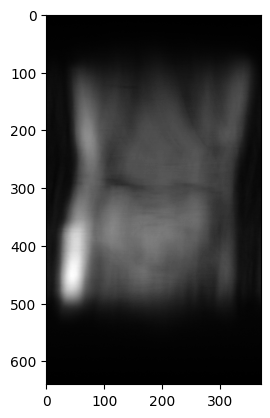

In [13]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

# Simulating Under-Sampled Data

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [19]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [20]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [25]:
sampled_image = fastmri.ifft2c(masked_kspace)            # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

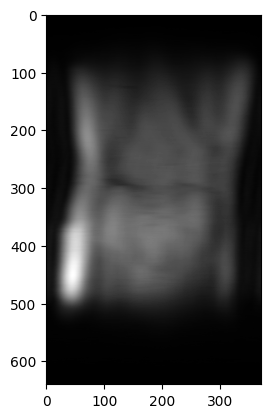

In [26]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

# Calculating Reconstruction Error (NMSE, PSNR, SSIM)

In [23]:
import os

def recon_errors(original_dir, recon_dir):
    # assign directory
    #directory = 'fastmri_examples/unet/output_test/reconstructions'
    
    nmse = []
    psnr = []
    ssim = []

    # iterate over files in
    # that directory
    for filename in os.listdir(recon_dir):

        #testing image (the original)
        val_image = f'{original_dir}/{filename}'
        hf = h5py.File(val_image)
        val_kspace = hf['kspace'][()]
        slice_kspace2 = T.to_tensor(val_kspace)      # Convert from numpy array to pytorch tensor
        slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
        slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
        slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
        length = slice_image_abs.shape[1]
        width = slice_image_abs.shape[2]
        pad_l = (length - 320)//2
        pad_w = (width - 320)//2
        true_image = slice_image_abs[:,pad_l:(length-pad_l), pad_w:(width-pad_w)]

        #reconstructed image
        recon_image = f'{recon_dir}/{filename}'
        recon_hf = h5py.File(recon_image)
        pred_image = torch.tensor(recon_hf['reconstruction'][()].squeeze(1))

        #nmse
        nmse.append(evaluate.nmse(true_image.numpy(), pred_image.numpy()))

        #psnr
        psnr.append(evaluate.psnr(true_image.numpy(), pred_image.numpy()))

        #ssmr
        ssim.append(evaluate.ssim(true_image.numpy(), pred_image.numpy()))
    
    return np.mean(nmse), np.mean(psnr), np.mean(ssim)